# Movie Recommendation Predict - Preprocessing

![image info](https://user-images.githubusercontent.com/33485020/108069438-5ee79d80-7089-11eb-8264-08fdda7e0d11.jpg)

### Honour Code

Idongesit Bokeime, Ngawetu Mtirara, Daniel Uwaoma, Sibusiso Sibiya, Nonokazi Cele, Mbuyiselo Mkwanazi, Collins Kgooho and Pharis Ihaki (Team_CW3), confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.


### Problem Statement

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, EDSA is challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity. (To be fixed, copied from kaggle)

### Objectives

1.   Explore and visualize the dataset.
2.   Clean and engineer the dataset.
3.   Build multiple models that will analyse sentiments on climate change      make the necesssary predictions.
4.   Assess the accuracy of the models.
5.   Choose the best model to make predictions.

# Table of contents:
- [1. Import libraries and datasets](#section-one)
  * [1.1. Loading the data](#subsection-one)
- [2. Dataset at a glance](#section-two)
- [3. Preprocessing](#section-three)
  * [3.1. Add new column](#subsection-one)
  * [3.2. Hashtag extraction](#subsection-two)
  * [3.3. Cleaning the corpus](#subsection-three)
  * [3.4. Parts of speech tagging and lemmatization](#subsection-four)
  * [3.5. Word frequency](#subsection-five)
  * [3.6. Named entity extraction](#subsection-six)
- [4. Exploratory data analysis](#section-four)
  * [4.1. Target variable distribution](#subsection-one)
  * [4.2. Tweet length distribution](#subsection-two)
  * [4.3. Climate change buzzwords](#subsection-three)
  * [4.4. Hashtags](#subsection-four)
  * [4.5. Named Entity Recognition](#subsection-five)
- [5. Model building](#section-five)
  * [5.1. Train-validation split](#subsection-one)
  * [5.2. Pipelines](#subsection-three)
  * [5.3. Model training](#subsection-four)
- [6. Model evaluation](#section-six)
  * [6.1. Logging on Comet](#subsection-one)
  * [6.2. Hyperparameter Tuning](#ubsection-two)
- [7. Conclusion](#section-seven)
- [8. Submission](#section-eight)
- [9. References](#section-nine)

 <a id="two"></a>
## 1. Importing Libraries

In [1]:
# Import our regular old heroes 
import numpy as np
import pandas as pd
import scipy as sp # <-- The sister of Numpy, used in our code for numerical efficientcy. 
import matplotlib.pyplot as plt
import seaborn as sns

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

<a id="three"></a>
### 1.1. Loading the Data
<a class="anchor" id="1.1">

### a) Ratings Data (train.csv)

- All ratings are contained in the file train.csv. Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

**userId, movieId, rating, timestamp**

-- The lines within this file are ordered first by userId, then, within user, by movieId.

-- Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

-- Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [3]:
# Load ratings data.

pd.set_option('display.max_columns', None)

ratings_df = pd.read_csv('train.csv')
print(ratings_df.shape)
ratings_df.head()

(10000038, 4)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


### b) imdb_data.csv

Additional movie metadata scraped from IMDB using the links.csv file with the following format
**movieId, title_cast, director, runtime, budget, plot_keywords**

-- The runtime shows the length of the movies in minutes and we will drill down to get more information on our movies.

In [4]:
# Load imdb data.
import pandas as pd
pd.set_option('display.max_columns', None)

runtime_df = pd.read_csv('imdb_data.csv')
print(runtime_df.shape)
runtime_df.head()

(27278, 6)


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


### c) Movies Data (movies.csv)

Movie information is contained in the file movies.csv. Each line of this file after the header row represents one movie, and has the following format: `movieId, title(year of release), genres`

Genres are a pipe-separated list, and are selected from the following:

`Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western, (no genres listed)`

In [5]:
movies_df = pd.read_csv('movies.csv')
print(movies_df.shape)
movies_df.head()

(62423, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
scores_df = pd.read_csv('genome_scores.csv')
print(scores_df.shape)
scores_df.head()

(15584448, 3)


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [ ]:
links_df = pd.read_csv('links.csv')
print(links_df.shape)
links_df.head()

<a id="section-two"></a>
## 2. Datasets at a glance

#### a) Ratings

- Let's look at a distribution of the ratings by users. Higher ratings (greater than or equal to 3.5 shows the movie watchers found the movie facinating. Below 3.5 is unfavourable ratings

Average rating in dataset: 3.5333951730983424


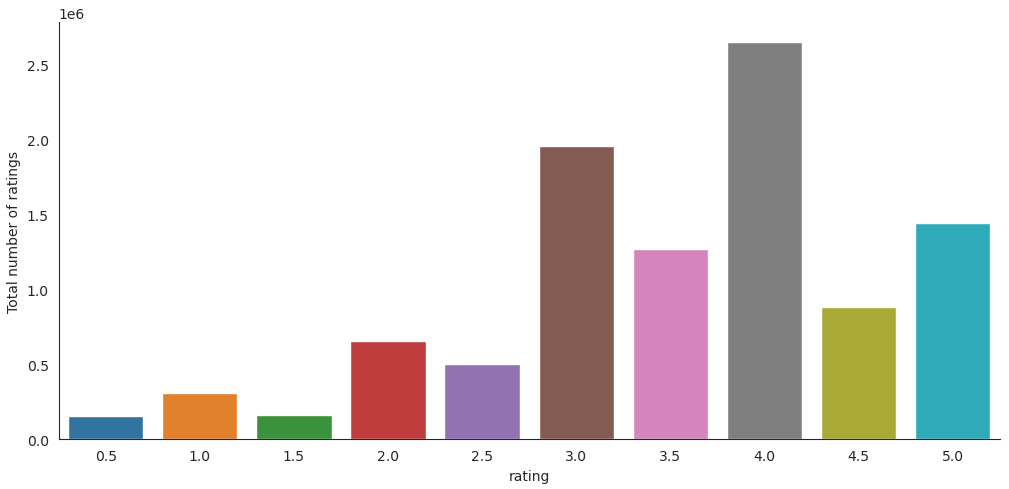

In [8]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=ratings_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(ratings_df["rating"])}')

#### b) Runtime
- Let's look at a distribution of the runtime for each movie. Most movies are within average runtime. Who wants to spend all day watching a single movie!.

Average movie runtime: 100.31233129238265


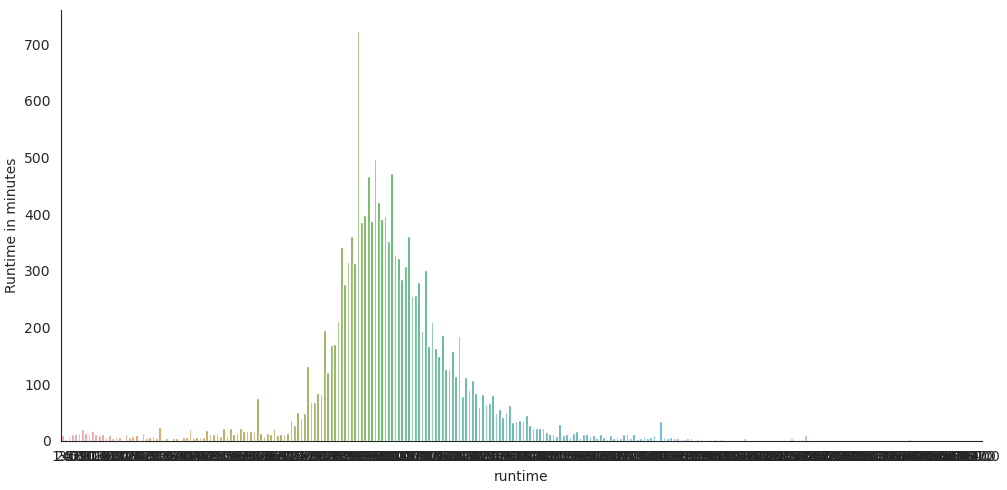

In [9]:
with sns.axes_style('white'):
    g = sns.factorplot("runtime", data=runtime_df, aspect=2.0,kind='count')
    g.set_ylabels("Runtime in minutes")
print (f'Average movie runtime: {np.mean(runtime_df["runtime"])}')

<a id="section-three"></a>
## 3. Preprocessing data

In [10]:
# Extract movies with runtime between 60 and 150 minutes which we believe has the most of the movies.
# also elimiante outliers in this regards.
runtime_df = runtime_df[(runtime_df.runtime >= 60) & (runtime_df.runtime <= 150)]
runtime_df.shape

(14149, 6)

In [11]:
# Drop the irrelevant attributes.
runtime_df.drop(['budget', 'plot_keywords'],
               axis=1, inplace=True)
print(runtime_df.shape)
runtime_df.head()

(14149, 4)


,movieId,title_cast,director,runtime
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0


In [12]:
runtime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 27277
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   movieId     14149 non-null  int64  
 1   title_cast  14035 non-null  object 
 2   director    14128 non-null  object 
 3   runtime     14149 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 552.7+ KB


In [13]:
# Drop the instances with duplicated ID.
runtime_df.sort_values(by='movieId', inplace=True)
runtime_df.drop(runtime_df[runtime_df.movieId.duplicated(keep=False)].index[0::2], axis=0, inplace=True)

# Fill the null values of director and title_cast with '[]'.
runtime_df.director.fillna('[]', inplace=True)
runtime_df.title_cast.fillna('[]', inplace=True)

# Drop all null values and duplicates.
runtime_df.dropna(inplace=True)
runtime_df.drop_duplicates(inplace=True)
print(runtime_df.shape)
runtime_df.head()

(14149, 4)


,movieId,title_cast,director,runtime
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0


In [14]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [15]:
movies_df['year'] = movies_df['title'].str[-5:-1]#.astype(int)
movies_df['title'] = movies_df['title'].str[:-6]
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [16]:
print(movies_df.shape)

(62423, 4)


In [17]:
# Extract movieIds in movies_df based on the movies left from runtime_df.
movies_df = movies_df[movies_df.movieId.isin(runtime_df.movieId)]
movies_df = movies_df.drop_duplicates()
movies_df.sort_values('movieId', inplace=True)
#movies_df.drop(movies_df[links_df.tmdbId.duplicated(keep=False)].index[0::2], axis=0, inplace=True)
#links_df.reset_index(drop=True, inplace=True)
print(movies_df.shape)
movies_df.head()

(12739, 4)


,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [18]:
main_df = movies_df.merge(runtime_df, how = 'inner', on = ['movieId'])
print(main_df.shape)
main_df.head()

(12739, 7)


,movieId,title,genres,year,title_cast,director,runtime
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0
1,2,Jumanji,Adventure|Children|Fantasy,1995,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0
2,3,Grumpier Old Men,Comedy|Romance,1995,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0
4,5,Father of the Bride Part II,Comedy,1995,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0


In [35]:
# Export main_df to movies_metadata_cleaned.csv file.
import os
newpath = r"Desktop"
if not os.path.exists(newpath):
    os.makedirs(newpath)
main_df.to_csv(newpath + "/movies_metadata_cleaned.csv", index=False)

### One Hot Encoding Movies Metadata

In [19]:
movies_ohe = main_df.copy()

In [22]:
# One hot encoding all the genres and check the dimensions.
all_genres = movies_ohe.genres.str.get_dummies()
all_genres.shape

(12739, 20)

In [23]:
# Value counts for each genre.
all_genres.sum().sort_values(ascending=False)

Drama                 6520
Comedy                4119
Thriller              2393
Romance               1955
Action                1729
Crime                 1438
Documentary           1312
Horror                1143
Adventure              986
Sci-Fi                 767
Mystery                686
Fantasy                682
Children               591
Animation              433
War                    378
Musical                303
IMAX                   149
Western                101
(no genres listed)      74
Film-Noir               33
dtype: int64

In [24]:
# Append the one hot encoded genres to the movies_ohe.
movies_ohe.drop("genres", axis=1, inplace=True)
movies_ohe = pd.concat([movies_ohe, all_genres], axis=1)
print(movies_ohe.shape)
movies_ohe.head()

(12739, 26)


,movieId,title,year,title_cast,director,runtime,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
# One hot encoding all the directors and check the dimensions.
all_directors = movies_ohe.director.str.get_dummies()
all_directors.shape

(12739, 8804)

In [26]:
# Value counts for each director.
all_directors.sum().sort_values(ascending=False)

Luc Besson          25
Woody Allen         24
Stephen King        22
See full summary    19
[]                  16
                    ..
Israel Cárdenas      1
Iskander Galiev      1
Isao Takahata        1
Isabelle Holland     1
Øystein Karlsen      1
Length: 8804, dtype: int64

In [27]:
# Select the directors that occured at least 10 times and check the dimensions.
selected_directors = all_directors.loc[:, all_directors.sum() >= 10]
selected_directors.shape

(12739, 25)

In [28]:
# Append the one hot encoded directors to the movies_ohe.
movies_ohe.drop("director", axis=1, inplace=True)
movies_ohe = pd.concat([movies_ohe, selected_directors], axis=1)
print(movies_ohe.shape)
movies_ohe.head()

(12739, 50)


,movieId,title,year,title_cast,runtime,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Abbas Kiarostami,Alex Gibney,Anders Thomas Jensen,Clive Barker,David Mamet,François Ozon,John Sayles,Kevin Smith,Ki-duk Kim,Lars von Trier,Luc Besson,Michael Crichton,Michael Haneke,Olivier Assayas,Pedro Almodóvar,Peter Farrelly,Robert Rodriguez,Sang-soo Hong,See full summary,Stephen King,Takeshi Kitano,William Shakespeare,Wim Wenders,Woody Allen,[]
0,1,Toy Story,1995,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,81.0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,104.0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,101.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale,1995,Whitney Houston|Angela Bassett|Loretta Devine|...,124.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,Steve Martin|Diane Keaton|Martin Short|Kimberl...,106.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# One hot encoding all the characters and check the dimensions.
all_title_cast = movies_ohe.title_cast.str.get_dummies()
all_title_cast.shape

(12739, 94108)

In [30]:
# Value counts for each character.
all_title_cast.sum().sort_values(ascending=False)

[]                            90
Samuel L. Jackson             74
Steve Buscemi                 60
Nicolas Cage                  52
Bruce Willis                  52
                              ..
Inka Vogt                      1
Inka Pohjonen                  1
Inka Nuorgam                   1
Inka Malovic                   1
Þórunn Magnea Magnúsdóttir     1
Length: 94108, dtype: int64

In [33]:
# Select the cast that occured at least 30 times and check the dimensions.
selected_cast = all_title_cast.loc[:, all_title_cast.sum() >= 30]
selected_cast.shape

(12739, 188)

In [34]:
# Append the one hot encoded casts to the movies_ohe.
movies_ohe.drop("title_cast", axis=1, inplace=True)
movies_ohe = pd.concat([movies_ohe, selected_cast], axis=1)
print(movies_ohe.shape)
movies_ohe.head()

(12739, 237)


,movieId,title,year,runtime,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Abbas Kiarostami,Alex Gibney,Anders Thomas Jensen,Clive Barker,David Mamet,François Ozon,John Sayles,Kevin Smith,Ki-duk Kim,Lars von Trier,Luc Besson,Michael Crichton,Michael Haneke,Olivier Assayas,Pedro Almodóvar,Peter Farrelly,Robert Rodriguez,Sang-soo Hong,See full summary,Stephen King,Takeshi Kitano,William Shakespeare,Wim Wenders,Woody Allen,[],Adam Sandler,Adrien Brody,Alan Cumming,Alec Baldwin,Alfred Molina,Allison Janney,Anthony Hopkins,Antonio Banderas,Ben Affleck,Ben Kingsley,Ben Stiller,Bill Murray,Bill Nighy,Bill Pullman,Billy Bob Thornton,Bob Hoskins,Brad Pitt,Brendan Gleeson,Brian Cox,Bruce Davison,Bruce Greenwood,Bruce McGill,Bruce Willis,Cameron Diaz,Catherine Keener,Charlize Theron,Chris Cooper,Christian Bale,Christian Slater,Christina Ricci,Christopher McDonald,Christopher Plummer,Christopher Walken,Ciarán Hinds,Colin Firth,Dan Aykroyd,Danny DeVito,Danny Glover,David Koechner,David Strathairn,David Thewlis,Denis Leary,Dennis Quaid,Denzel Washington,Dermot Mulroney,Donald Sutherland,Ed Harris,Elias Koteas,Eric Roberts,Ethan Hawke,Ewan McGregor,Forest Whitaker,Gabriel Byrne,Gary Oldman,George Clooney,Greg Kinnear,Guy Pearce,Gwyneth Paltrow,Gérard Depardieu,Hank Azaria,Harvey Keitel,Heather Graham,Helen Mirren,Helena Bonham Carter,J.K. Simmons,Jackie Chan,James Cromwell,James Franco,James Gandolfini,James Marsden,James Rebhorn,James Woods,Janeane Garofalo,Jason Flemyng,Jason Statham,Jean Reno,Jeff Bridges,Jeff Daniels,Jeffrey Tambor,Jeremy Piven,Jet Li,Jim Broadbent,Joan Cusack,John C. Reilly,John Cusack,John Goodman,John Hurt,John Leguizamo,John Malkovich,John Travolta,John Turturro,Johnny Depp,Jude Law,Julianne Moore,Juliette Binoche,Juliette Lewis,Justin Long,Kathy Bates,Keanu Reeves,Keith David,Kevin Bacon,Kevin Corrigan,Kevin Pollak,Kevin Spacey,Kirsten Dunst,Kristin Scott Thomas,Laura Linney,Laurence Fishburne,Liam Neeson,Liev Schreiber,Lili Taylor,Luis Guzmán,Luke Wilson,Malcolm McDowell,Marcia Gay Harden,Marisa Tomei,Mark Ruffalo,Mark Strong,Mark Wahlberg,Matt Damon,Matthew Lillard,Michael Caine,Michael Gambon,Michael Madsen,Michael Rapaport,Morgan Freeman,Nick Nolte,Nicolas Cage,Nicole Kidman,Oliver Platt,Owen Wilson,Parker Posey,Patricia Clarkson,Paul Giamatti,Paul Rudd,Penélope Cruz,Peter Stormare,Philip Seymour Hoffman,Pierce Brosnan,Ralph Fiennes,Ray Liotta,Ray Winstone,Richard Gere,Richard Jenkins,Richard Riehle,Robert De Niro,Robert Downey Jr.,Robert Duvall,Robert Patrick,Robin Williams,Ron Perlman,Rosario Dawson,Salma Hayek,Sam Rockwell,Sam Shepard,Samuel L. Jackson,Sandra Bullock,Scarlett Johansson,Sean Bean,Sean Penn,Seymour Cassel,Stanley Tucci,Stellan Skarsgård,Stephen Tobolowsky,Steve Buscemi,Steve Zahn,Susan Sarandon,Terrence Howard,Tilda Swinton,Timothy Spall,Tom Wilkinson,Tommy Lee Jones,Toni Collette,Udo Kier,Uma Thurman,Val Kilmer,Vince Vaughn,Vincent D'Onofrio,Ving Rhames,Wallace Shawn,Whoopi Goldberg,Will Ferrell,Willem Dafoe,William H. Macy,William Hurt,Winona Ryder,Woody Harrelson,[]
0,1,Toy Story,1995,81.0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,104.0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0

In [36]:
# Export movies_ohe to movies_metadata_ohe.csv file.
import os
newpath = r"Desktop"
if not os.path.exists(newpath):
    os.makedirs(newpath)
movies_ohe.to_csv(newpath + "/movies_metadata_ohe.csv", index=False)

#### Working with ratings data in conjunction with our movies_ohe dataset

In [37]:
# Extract ratings based on the movies left in the movies_ohe and the ratings should be at least 3.5 (out of 5).
ratings_df = ratings_df[(ratings_df.movieId.isin(movies_ohe.movieId)) & (ratings_df.rating >= 3.5)]

# Sort ratings_df by userId and timestamp, then drop the rating and timestamp attributes.
ratings_df.sort_values(by=['userId', 'timestamp'], ignore_index=True, inplace=True)
ratings_df.drop(['rating', 'timestamp'], axis=1, inplace=True)
print(ratings_df.shape)
ratings_df.head()

(3811242, 2)


,userId,movieId
0,1,3949
1,1,1175
2,1,2843
3,1,7365
4,1,4973


In [38]:
# Group all movieId by userId for association rules mining
ratings_all = ratings_df.groupby("userId")["movieId"].apply(list).reset_index()
print(ratings_all.shape)
ratings_all.head()

(160289, 2)


,userId,movieId
0,1,"[3949, 1175, 2843, 7365, 4973, 6016, 7323, 695..."
1,2,"[1653, 5445, 151, 236, 4886, 333, 4299, 1488, ..."
2,3,"[593, 2571, 30793, 41566, 112552, 116797, 4306..."
3,4,"[97913, 101864, 107406, 93838, 49272, 8961, 10..."
4,5,"[150, 32, 216, 340, 50, 593, 350, 47, 356, 141..."


In [39]:
# Export ratings_all data to ratings_all.csv file
import os
newpath = r"Desktop"
if not os.path.exists(newpath):
    os.makedirs(newpath)
ratings_all.to_csv(newpath + "/ratings_all.csv", index=False)

#### Generate ratings data subset

In [40]:
# Insert movie ID into all_genres
all_genres.insert(0, "id", movies_ohe.movieId)
all_genres.head()

,id,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
# Group movieId by userId for each genre for association rules mining
ratings_subsets = {"Genre": list(), "Data": list()}
for cn in all_genres.columns[1:]:
    ID = all_genres.loc[all_genres[cn] == 1, "id"]
    subset = ratings_df[ratings_df.movieId.isin(ID)]
    data = subset.groupby("userId")["movieId"].apply(list).reset_index()
    ratings_subsets["Genre"].append(cn)
    ratings_subsets["Data"].append(data)
    print(cn + ":", data.shape)

(no genres listed): (64, 2)
Action: (134273, 2)
Adventure: (127149, 2)
Animation: (85529, 2)
Children: (88590, 2)
Comedy: (144893, 2)
Crime: (131045, 2)
Documentary: (25437, 2)
Drama: (151864, 2)
Fantasy: (99600, 2)
Film-Noir: (25318, 2)
Horror: (76855, 2)
IMAX: (71808, 2)
Musical: (55909, 2)
Mystery: (105446, 2)
Romance: (132467, 2)
Sci-Fi: (115615, 2)
Thriller: (142422, 2)
War: (70179, 2)
Western: (29359, 2)


In [42]:
# Export all ratings subsets to respective csv file
newpath = r"Desktop/ratings_subsets"
if not os.path.exists(newpath):
    os.makedirs(newpath)
for i in range(len(ratings_subsets["Genre"])):
    filename = "ratings_{}.csv".format(ratings_subsets["Genre"][i].replace(" ", "_").lower())
    ratings_subsets["Data"][i].to_csv(newpath + "/" + filename, index=False)

<a id="section-two"></a>
## 3. Exploratory data analysis

<a id="section-two"></a>
## 4. Feature Engineering

<a id="section-two"></a>
## 5. Recommender Systems

<a id="three"></a>
### 5.1. Content Filtering-Based Recommender System
<a class="anchor" id="1.1">

<a id="three"></a>
### 5.2. Collaborative Filtering-Based Recommender System
<a class="anchor" id="1.1">

<a id="section-six"></a>
## 6. Model evaluation

<a id="section-seven"></a>
## 7. Model Selection 

<a id="section-seven"></a>
## 8. Conclusion

<a id="section-eight"></a>
## 9. Submission

<a id="three"></a>
### 9.1. Creating pickle files of the models
<a class="anchor" id="1.1">

<a id="three"></a>
### 9.2.  Creating kaggle submission file
<a class="anchor" id="1.1">

<a id="section-nine"></a>
## 10. References 